# Introduction to Language Models - Makemore part 2

Character level language model that makes more of the training data that is sent to it


In [764]:
# Import libraries
import os
import random
from striprtf.striprtf import rtf_to_text
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import functional as F

In [765]:
# Block containing all the hyperparameters
block_size = 5 # Number of characters/tokens to be processed in the model
batch_size = 32 # Number of blocks to be processed in parallel
max_iters = 10000 # Num of iterations to train the model
learning_rate = 0.1 # Learning rate 
n_embd = 2 # Num of dimensions in the embedding layer

# Num of inputs to the hidden layer
n_in = block_size * n_embd # Bexcause we have n_embd dimensional embeddings and we have 5 (block size) of them
n_hidden = 128 # Num of neurons in the hidden layer. We can take any number we want. We are starting with 128
n_biases = n_hidden # Num of biases in the hidden layer. Keeping 1 bias for each neuron

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # For M1 Mac

torch.manual_seed(42)

In [766]:
# Import input text file and read it line by line
in_filepath = os.getcwd() + "/data/in/MakeMore/"
with open(in_filepath+'input.rtf', 'r', encoding='utf-8') as f:
    rtf = f.read()

# Convert RTF to text
text = rtf_to_text(rtf)

# Split text as a list
words = text.splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Part 1: Building the neural net

In [767]:
# First, we create a simple vocabulary/ lookup table that maps each character to an integer and vice versa. 
chars = sorted(list(set(''.join(words))))

# Create a simple iterator to convert the characters in our input text to integers and vice versa.
stoi = {s:i+1 for i,s in enumerate(chars)}

# Add indexes for the start and end tokens
stoi['.'] = 0

# Create an inverse dictionary to convert the integers back to characters
itos = {i:s for s,i in stoi.items()}

# Get total num of chars. This will be used heavily later
num_chars = len(stoi)

In [768]:
# ---- Common functions ----


# Function to build the dataset
def build_dataset(words, block_size):
    # Initialize the input and output sequences
    X, Y = [], []

    # Create rolling windows of the input text to create the context and target sequences
    for w in words:
        #print(w)
        context = block_size * [0]
        
        for ch in w + '.':
            # Get the integer representation of the character
            ix = stoi[ch]

            # Add the integer to the input sequence
            X.append(context.copy())

            # Add the integer to the output sequence
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix] # Crop and append

    # Convert to tensors
    X = torch.tensor(X, dtype=torch.long, device=device)
    Y = torch.tensor(Y, dtype=torch.long, device=device)
    print(f'X shape: {X.shape}, Y shape: {Y.shape}')

    # Return the input and output sequences
    return X, Y


# Function to reinitialize the weights and biases
def reinitialize_weights(num_chars, n_embd, n_in, n_hidden, n_biases):
    
    g = torch.Generator(device=device).manual_seed(42) # For reproducibility
    C = torch.randn((num_chars, n_embd), device=device, generator=g) # We use 2 because we just have 27 characters to deal with

    # Create a random set of weights for the hidden layer
    W1 = torch.randn((n_in, n_hidden), device=device, generator=g)
    B1 = torch.randn((n_biases), device=device, generator=g)

    # Create a random set of weights for the output layer
    W2 = torch.randn((n_hidden, num_chars), device=device, generator=g)
    B2 = torch.randn((num_chars), device=device, generator=g) # Create a random set of biases for the output layer

    # Create an array to store the loss values
    params = [C, W1, B1, W2, B2]
    for param in params:
        param.requires_grad = True # For params, set requires_grad to True (very important for the model training)

    return params



We will create a block of characters this time. This is essentially - how many characters do we take to predict the next one

In [769]:
# Shuffle the words randomly
random.seed(42) # For reproducibility
random.shuffle(words)

# Split pointers
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Create the train, validation and test sets
X_train, Y_train = build_dataset(words[:n1], block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

X shape: torch.Size([182625, 5]), Y shape: torch.Size([182625])
X shape: torch.Size([22655, 5]), Y shape: torch.Size([22655])
X shape: torch.Size([22866, 5]), Y shape: torch.Size([22866])


In [770]:
# Create a dataset from the input and output sequences. Start by creating a TensorDataset of dimensions (num_chars, 2)
# C = torch.randn((num_chars, 2), device=device) # We use 2 because we just have 27 characters to deal with

# Create embedding layer for all the characters using torch indexing
# emb = C[X_train] # handled inside the model

# The shape of embedding layer should be (num_chars, block_size, 2). T
# Essentially, for every context line, we have a 2D embedding
# emb.shape

#### Constructing the hidden layer

In [771]:
# ---- Moved to variables above ----

# Num of inputs to the hidden layer
#n_in = block_size * 2 # Bexcause we have 2 dimensional embeddings and we have 5 (block size) of them

# Num of neurons in the hidden layer
#n_hidden = 128 # We can take any number we want. We are starting with 128

# Num of biases in the hidden layer
#n_biases = n_hidden # Keeping 1 bias for each neuron

# Create a random set of weights for the hidden layer
#W1 = torch.randn((n_in, n_hidden), device=device)
#B1 = torch.randn((n_biases), device=device)



Typically what we want to do is that we want to implement W @ x + B

However, this is an issue as the dimension of W => (n_in, n_hidden) and that of X => (len(emb), block_size, 2)
hence, we cannot simply multiply the terms. In order to multiply these terms, we need to reshape W. There are several ways to do this in PyTorch such as torch.cat, torch.unbind, etc. However, there is a much more efficient way to reshaping the tensors called "view". It is efficient as it is not changint he physical storage attributes, but just manipulating some 'metadata' of how it is represented. For example, a tensor having 18 elements will always be stored as a single array of 18 blocks, however we can write the same as 

All these shapes are considered valid since they multiply to the same number 18
tnsr.view(18) == tnsr.view(9, 2) == tnsr.view(2, 9) == tnsr.view(3, 3, 2) == tnsr.view(6, 3) == tnsr.view(3, 2, 3)

In [772]:
# Reshaping the tensors to make the matrix multiplication happen
# emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])

# Hidden layer output = (input * weights) + biases
# h = emb_reshaped @ W1 + B1

# Pass the output of the hidden layer through a tanh activation function
# h = torch.tanh(h)
# print(f'Shape of hidden layer: {h.shape}')
# h

#### Output layer

The final layer (before output) will have 27 possible outputs i.e. 1 for each character. Based on the probabilities we get for each of the characters, we can then use a softmax function to give us a single character prediction

In [773]:
# ---- Moved to variables above ----

# Create a random set of weights for the output layer
#W2 = torch.randn((n_hidden, num_chars), device=device)

# Create a random set of biases for the output layer
#B2 = torch.randn((num_chars), device=device)

# Output layer output = (input * weights) + biases
# logits = h @ W2 + B2
# logits.shape

In [774]:
# the next of steps are similar to the ones in Makemore part 1 notebook. Details are mentioned there about the steps
# However, this time we will use the cross entropy loss function from the torch.nn.functional module instead of the commented steps below
# Cross Entropy loss is much more efficient and faster than the formula above since it is implemented in C++ and is highly optimised. Cross entropy loss does not create any intermediate tensors and hence is more memory efficient.
# Furthermore, the cross entropy loss function is more numerically stable than the formula above as it can handle very large positive and very large negative numbers
# loss = F.cross_entropy(logits, Y)
# loss

# ---- Cross entropy replaces all the steps below in this code cell ----

# Calculate the counts
# counts = logits.exp() # Equivalent of N in Makemore part 1 i.e. generating the counts

# Normalise the counts into a probability distribution
# probs = counts / counts.sum(dim=1, keepdim=True) # Equivalent of P in Makemore part 1 i.e. generating the probabilities based on the counts
# print(f'Shape of outputs layer: {probs.shape}')

# Get the probability of the correct character
# we use the Y tensor to get the correct character. For each row in the Y tensor, we get the corresponding probability from the probs tensor
# probs =  probs[torch.arange(len(probs)), Y]

# Calculate the loss (similar to the Makemore part 1 notebook loss calculation). Check MakeMore part 1 notebook for details behind the formula
# loss = -probs.log().mean()

#### Create the complete neural net - Basic model

Combining the steps above and putting them in a loop to train the network

In [775]:
# ---- Model Functions ----

# Create a function to calculate the loss and update the parameters
def optimise_training_parameters(params, iters, lr_decay=False):
    # Create an array to store the loss values
    stepi = []
    lossi = []
    
    # Get weights and biases
    C = params[0]; W1 = params[1]; B1 = params[2]; W2 = params[3]; B2 = params[4]

    # Calculate the gradients
    for i in range(iters):

        # Create a mini batch
        # We do that by randomly selecting a batch size number of indices from the X tensor. We then use those indices to get the corresponding values from the X and Y tensors
        # For example, if the batch size is 4 and the X tensor has 10 rows, then we will randomly select 4 indices from the X tensor. Let's say the indices are 2, 4, 6 and 8 (indices start from 0) 
        # Then we will use those indices to get the corresponding values from the X and Y tensors. For example, X[2] will give us the 3rd row of the X tensor and Y[2] will give us the 3rd row of the Y tensor
        # We will repeat this process for the entire batch size. We will then use the mini batch to calculate the loss and update the parameters
        batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,), device=device)

        # Forward pass
        emb = C[X_train[batch_indexes]]
        emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
        h = emb_reshaped @ W1 + B1
        h = torch.tanh(h)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y_train[batch_indexes])

        # Backward pass
        for p in params:
            p.grad = None
        loss.backward()

        # Update the parameters
        if (i > max_iters * 0.8) & lr_decay==True: 
            lr=learning_rate*0.1 
        else: 
            lr=learning_rate
        for p in params:
            p.data -= lr * p.grad
        
        # Track stats
        stepi.append(i)
        lossi.append(loss.log10().item())

    # Print training loss
    print(f'Loss after training {iters} iters = {loss}\n')

    # Return the loss values
    return stepi, lossi, params


# Calculate the loss on any complete dataset
def model_loss(params, X, Y):
    # Disable gradient tracking
    # @torch.no_grad() is a Python decorator provided by PyTorch that can be used to temporarily disable gradient computation, which can save memory and computation time. 
    # When you apply this decorator to a function or a code block, any computation that involves gradients will not be tracked by PyTorch's autograd system, and no new 
    # computational graph nodes will be created. This can be useful in scenarios where you want to perform some computation without building up gradients in order to avoid 
    # memory overflow, or when you want to do inference on a pre-trained model without updating its parameters.
    with torch.no_grad():
        # Get weights and biases
        C = params[0]; W1 = params[1]; B1 = params[2]; W2 = params[3]; B2 = params[4]
        
        emb = C[X]
        emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
        h = emb_reshaped @ W1 + B1
        h = torch.tanh(h)
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y)
    return loss


# Generate sample output
def generate_output_samples(num_samples, params):
    # Get weights and biases
    C = params[0]; W1 = params[1]; B1 = params[2]; W2 = params[3]; B2 = params[4]    
    
    for _ in range(num_samples):
        out = []
        context = block_size * [0]
        while True:
            emb = torch.tensor(C[context]) # 1 x block_size x dim
            emb_reshaped = emb.view(1, -1)
            h = emb_reshaped @ W1 + B1
            h = torch.tanh(h)
            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            next_char = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [next_char]
            out.append(next_char)
            if next_char == 0:
                break
        print(''.join([itos[i] for i in out]))



In [776]:
# Create the parameters
params = reinitialize_weights(num_chars=num_chars,n_embd=n_embd, n_in=n_in, n_hidden=n_hidden, n_biases=n_biases)

# Train the model - Update the parameters
stepi, lossi, tuned_params = optimise_training_parameters(params, max_iters, lr_decay=False)

# Print the loss on the entire train set
print(f'Loss on train set = {model_loss(tuned_params, X_train, Y_train)}')

# Print the loss on the entire validation set
print(f'Loss on validation set = {model_loss(tuned_params, X_val, Y_val)}')


Loss after training 10000 iters = 2.476367473602295



We can see that the training and validation sets have similar losses. This indicates that there is no overfitting. This is likely due to the fact that this is a small model and is not powerful enough to be able to memorise all the data. We expect performance improvements by scaling up the model.

To improve the model, the following aspects could be considered

 - Learning rate
 - Learning rate decay
 - Regularisation
 - Batch size
 - Block size
 - Number of iterations

If these dont work, then we switch over to the architecture of the neural network
 - Number of layers
 - Number of neurons in each layer
 - Activation functions
 - Optimisers

Another thing to look out for is the embedding size for each character as it could be limiting the model's ability to learn complex relationships between the characters
 - Embedding size 
 
We have created a 2 dimensional embedding for each word. We can increase the number of dimensions to create a higher dimensional embedding. This will help the model to learn more complex relationships between the words. However, this will increase the number of parameters in the model and will increase the training time. We need to find the right balance between the number of dimensions and the training time

In [780]:
# Generate samples based on the trained model
generate_output_samples(10, tuned_params)

diwam.
jamiyah.
fheid.
kaim.
yaklyn.
myvinn.
kohli.
miuni.
aisinzyn.
iesla.


/var/folders/pj/3fn1xxdn4cz7gfp1g7pnb3dm0000gn/T/ipykernel_20017/2717808363.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(C[context]) # 1 x block_size x dim


#### Tuning the model

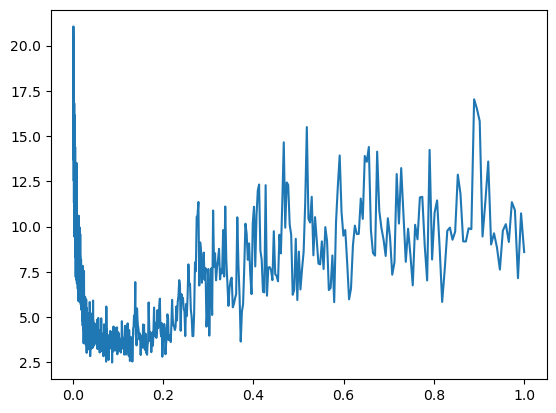

In [782]:
# ---- Identifying an ideal learning rate ----

# Reinitialize the parameters
params = reinitialize_weights(num_chars=num_chars,n_embd=n_embd, n_in=n_in, n_hidden=n_hidden, n_biases=n_biases)

# Create a range of learning rates. We will assume these to be exponents of the learning rates instead of the actual learning rates (to create a range of learning rates)
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # We are essentially stepping linearly between the exponents of the learning rates (10^-3 to 10^0)
# lrs

# Create a list to store the loss values and learning rates
losses = []
learning_rates = []

# Rerun the model from the beginning with the new learning rates
for lr in lrs[:1000]:
    # Get parameters
    C = params[0]; W1 = params[1]; B1 = params[2]; W2 = params[3]; B2 = params[4]
    
    # Minibatch construct
    batch_indexes = torch.randint(0, X_train.shape[0], (batch_size,), device=device)

    # Forward pass
    emb = C[X_train[batch_indexes]]
    emb_reshaped = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
    h = emb_reshaped @ W1 + B1
    h = torch.tanh(h)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y_train[batch_indexes])

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in params:
        p.data -= lr * p.grad

    # Track stats
    if loss.item() > 100:
        losses.append(100)
    else:
        losses.append(loss.item())
    learning_rates.append(lr)


# Plot the learning rates vs the loss
plt.plot(learning_rates, losses)

It looks like a learning rate of around 0.1 is where the loss seems to be low. We can try the model on those learning rates. Lets retrain the model on the new learning rate. We will train this model with 3 overall changes:
 - learning rate of 0.1
 - learning rate decay = True
 - increase the number of iters to 30,000

In [784]:
# Create the parameters
params = reinitialize_weights(num_chars=num_chars,n_embd=n_embd, n_in=n_in, n_hidden=n_hidden, n_biases=n_biases)

# Train the model - Update the parameters
max_iters = 30000
learning_rate = 0.1
stepi, lossi, tuned_params = optimise_training_parameters(params, max_iters, lr_decay=True)

# Print the loss on the entire train set
print(f'Loss on train set = {model_loss(tuned_params, X_train, Y_train)}')

# Print the loss on the entire validation set
print(f'Loss on validation set = {model_loss(tuned_params, X_val, Y_val)}')

Loss after training 30000 iters = 2.1787257194519043

Loss on train set = 2.331892251968384
Loss on validation set = 2.3371872901916504


torch.Size([27, 2])


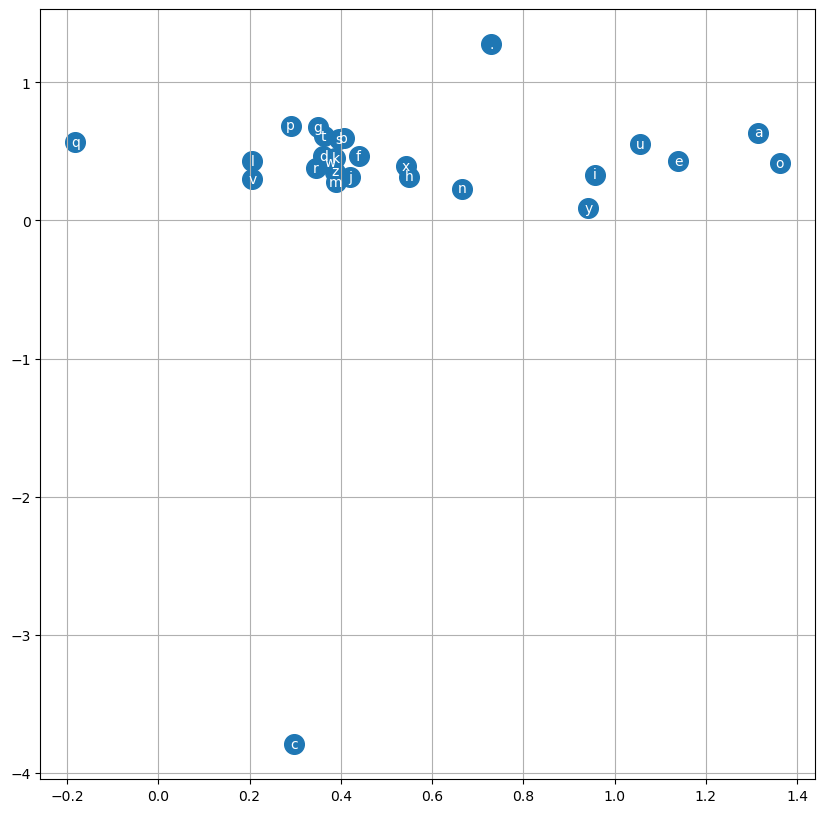

In [788]:
# ---- Embedding layer size ----

# Create the parameters
C = tuned_params[0]

# Visualise the embedding vectors while they are 2 dimensional (i.e. dim = 2)
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data.cpu().numpy(), C[:, 1].data.cpu().numpy(), s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white", fontsize=10)
plt.grid('minor')

There are some interesting observations to be made looking at the character embeddings in 2 dimensions. 

 - '.' is interpretted as a standalone charcater and is places away from everything else
 - Vowels are grouped separately as well, which is good and they are also spaced away from each other. This implies that the current model can predict vowels and correctly. 
 - Some characters such as 'q' can be predicted as well. This is probably due to the nature of their usage in english language. 

P.S:  Once we increase the dimensions of the embeddings, we will not be able to visualise the characters 

In [789]:
# New set of model parameters based on tuning
n_embd = 10
learning_rate = 0.1
n_hidden = 200 # Increasing the num of neuron to 200

# New set of params for the the hidden layer
n_in = block_size * n_embd # Beause we have n_embd dimensional embeddings and we have 5 (block size) of them
n_biases = n_hidden # Num of biases in the hidden layer. Keeping 1 bias for each neuron

# Parameters for the model
params = reinitialize_weights(num_chars=num_chars,n_embd=n_embd, n_in=n_in, n_hidden=n_hidden, n_biases=n_biases)

# Train the model - Update the parameters
max_iters = 100000
stepi, lossi, tuned_params = optimise_training_parameters(params, max_iters, lr_decay=True)

# Print the loss on the entire train set
print(f'Loss on train set = {model_loss(tuned_params, X_train, Y_train)}')

# Print the loss on the entire validation set
print(f'Loss on validation set = {model_loss(tuned_params, X_val, Y_val)}')


Loss after training 100000 iters = 2.573564052581787

Loss on train set = 2.2275779247283936
Loss on validation set = 2.2439069747924805


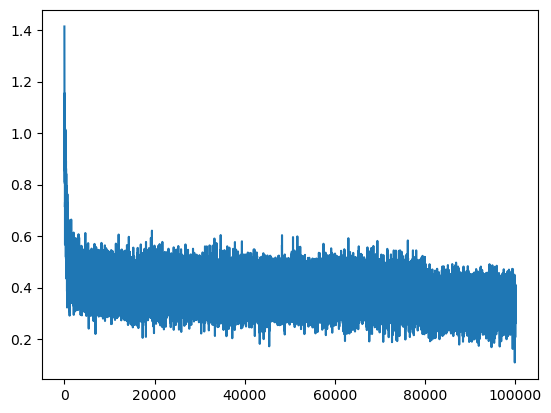

In [790]:
plt.plot(stepi, lossi)

In [792]:
# Generate samples from the trained model
generate_output_samples(10, tuned_params)

/var/folders/pj/3fn1xxdn4cz7gfp1g7pnb3dm0000gn/T/ipykernel_20017/2717808363.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(C[context]) # 1 x block_size x dim


zalleria.
avora.
mantyn.
teloah.
koula.
saoden.
kaleolon.
durlodaleey.
yarvie.
alsana.
